In [1]:
import os
import sys
import math
from copy import deepcopy

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
os.environ["CUDA_VISIBLE_DEVICES"]="7"
if torch.cuda.is_available():
    device = torch.cuda.device("cuda:7")
    use_cuda = True

In [2]:
class ExpLinear(nn.Module):
    def __init__(self, in_size):
        super(ExpLinear, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_size, 1))
        self.alpha = nn.Sequential(nn.Linear(1, 1, bias=False))
        def prnt(args):
            print ("grad: ", args)
            print ("val: ", self.cloned_x)
        #dict(self.alpha.named_parameters())['0.weight'].register_hook(prnt)
        self.cloned_x = None

    def forward(self, x):
        self.cloned_x = self.alpha(torch.exp(self.linear(x))).clone().detach()
        return self.alpha(torch.exp(self.linear(x)))
    
    def get_alpha(self):
        return get_pure(dict(self.alpha.named_parameters())['0.weight'])[0][0]
    
    def init_weigth(self, mean, std):
        for name, param in super(ExpLinear, self).named_parameters():
            param.data.normal_(mean, std)

In [3]:
class Classifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_size):
        super(Classifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x).view(-1)

In [5]:
class TwoCircleDataset(Dataset):
    def __init__(self, R1, R2, N, dim, train=False, normalize=True):
        self.R1 = R1
        self.R2 = R2
        self.N = N
        self.dim = dim
        self.train = train
        self.normalize = normalize  
        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        for idx in range(self.N):
            self.dots[idx] = self.normal_generator.sample_n(self.dim).view(1, -1)
            self.dots[idx] /= torch.sqrt(torch.sum(self.dots[idx] ** 2))
            self.classes[idx] = self.classes[idx]
            if self.classes[idx] == 1:
                self.dots[idx] *= self.R1
            else:
                self.dots[idx] *= self.R2
                
        self.mean = self.dots.mean(dim=0)
        self.std = self.dots.std(dim=0)
        
        if self.normalize:
            self.dots = (self.dots - self.mean.expand_as(self.dots)) / self.std.expand_as(self.dots)
            
        if use_cuda:
            self.dots = self.dots.cuda()
            self.classes = self.classes.cuda()
                
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])         

In [6]:
class TwoGaussiansDataset(Dataset):
    def __init__(self, M1, M2, N, dim, train=False):
        self.M1 = M1
        self.M2 = M2
        self.N = N
        self.dim = dim
        self.train = train
        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator_1 = torch.distributions.normal.Normal(torch.tensor([M1]), torch.tensor([1.0]))
        self.normal_generator_2 = torch.distributions.normal.Normal(torch.tensor([M2]), torch.tensor([1.0]))
        for idx in range(self.N):
            if self.classes[idx] == 1:
                self.dots[idx] = self.normal_generator_1.sample_n(self.dim).view(1, -1)
            else:
                self.dots[idx] = self.normal_generator_2.sample_n(self.dim).view(1, -1)
                
        if use_cuda:
            self.dots = self.dots.cuda()
            self.classes = self.classes.cuda()
        
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])

In [7]:
dataset_c_train = TwoCircleDataset(1, 1.01, 1000, 100, train=True)
dataset_c_test = TwoCircleDataset(1, 1.01, 1000, 100, train=False)
dataset_c_validation = TwoCircleDataset(1, 1.01, 1000, 100, train=False)
dataloader_c_train = DataLoader(dataset_c_train, batch_size=128, shuffle=True)
dataloader_c_test = DataLoader(dataset_c_test, batch_size=128, shuffle=True)
dataloader_c_validation = DataLoader(dataset_c_validation, batch_size=128, shuffle=True)

dataset_g_train = TwoGaussiansDataset(0., 0.1, 2000, 100, train=True)
dataset_g_test = TwoGaussiansDataset(0., 0.1, 2000, 100, train=False)
dataset_g_validation = TwoGaussiansDataset(0., 0.1, 2000, 100, train=False)
dataloader_g_train = DataLoader(dataset_g_train, batch_size=128, shuffle=True)
dataloader_g_test = DataLoader(dataset_g_test, batch_size=128, shuffle=True)
dataloader_g_validation = DataLoader(dataset_g_validation, batch_size=128, shuffle=True)

In [8]:
def get_pure(args):
    return args.data.cpu().clone().numpy()

In [9]:
def print_plots(data, axis, labels):
    N_plots = len(data)
    plt.figure(figsize=(30, (N_plots // 3 + 1) * 10))

    for idx in range(len(data)):
        plt.subplot(N_plots // 3 + 1, 3, idx + 1)
        for jdx in range(len(data[idx])):
            plt.plot(data[idx][jdx], label=labels[idx][jdx])
        plt.xlabel(axis[idx][0], fontsize=16)
        plt.ylabel(axis[idx][1], fontsize=16)
        plt.legend(loc=0, fontsize=16)

In [10]:
def train_strategy_NO_STOCH(network, loss_func, optimizer, dataloader, reg_lambda):
    for batch_dots, batch_labels in dataloader:
        x = Variable(batch_dots)
        correct_y = Variable(batch_labels.float())
        if use_cuda:
            x = x.cuda()
            correct_y = correct_y.cuda()

        predict_y = network(x)
        loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss, reg_loss = loss_func(network(dataloader.dataset.dots),
                               dataloader.dataset.classes, 
                               network, reg_lambda)
    misclass_rate = (np.where(get_pure(network(dataloader.dataset.dots)) < 0, -1, 1) != 
                     get_pure(dataloader.dataset.classes)).sum()
    
    return get_pure(loss), misclass_rate, get_pure(reg_loss)

In [11]:
def test_strategy_NO_STOCH(network, loss_func, optimizer, dataloader, reg_lambda):
    loss, reg_loss = loss_func(network(dataloader.dataset.dots),
                               dataloader.dataset.classes, 
                               network, reg_lambda)
    misclass_rate = (np.where(get_pure(network(dataloader.dataset.dots)) < 0, -1, 1) != 
                     get_pure(dataloader.dataset.classes)).sum()
    
    return get_pure(loss), misclass_rate, get_pure(reg_loss)

In [170]:
def loss_func_EXP(predict_y, correct_y, network, reg_lambda):
    loss = None
    reg_loss = None
    
    if use_cuda:
        loss = nn.HingeEmbeddingLoss()(predict_y, correct_y)**3
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor(1.).cuda(), torch.tensor(0.).cuda()) ** 3)
    else:
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor(1.), torch.tensor(0.)) ** 3)
    
    for param in network.explinear.alpha.parameters():
        reg_loss = float(reg_lambda) * param.norm(2)
        
    return loss + reg_loss, reg_loss

In [13]:
def loss_func(predict_y, correct_y, network, reg_lambda):
    loss = None
    reg_loss = None
    if use_cuda:
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor(1.).cuda(), torch.tensor(0.).cuda()) ** 3)
        reg_loss = torch.tensor(0.).cuda()
    else:
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor(1.), torch.tensor(0.)) ** 3)
        reg_loss = torch.tensor(0.)
    
    return loss + reg_loss, reg_loss

In [204]:
def train_EXP(network, loss_func,
              learning_rate, reinit_optim,
              train_strategy, test_strategy,
              reg_lambda,
              epochs,
              dataloader_train, dataloader_test,
              plot_graphs=True, verbose=False,
              epoch_hook=None):
    
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    alpha = []    
    reg_losses = []
    optimizer = None
    
    try:
        for epoch in range(epochs):
            if epoch % reinit_optim == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
            
            # train
            loss, misscl_rate, reg_loss = train_strategy(network, loss_func, optimizer, dataloader_train, reg_lambda)    
            losses_train.append(loss)
            misscl_rate_train.append(misscl_rate)
            
            #test
            loss, misscl_rate, _ =  test_strategy(network, loss_func, optimizer, dataloader_test, reg_lambda)
            losses_test.append(loss)
            misscl_rate_test.append(misscl_rate)
            
            alpha.append(network.get_alpha())
            reg_losses.append(reg_loss)
                
            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
            
            if epoch_hook is not None:
                epoch_hook(network=network, loss_func=loss_func,
                           learning_rate=learning_rate, reinit_optim=reinit_optim,
                           train_strategy=train_strategy, test_strategy=test_strategy,
                           reg_lambda=reg_lambda,
                           epochs=epochs, epoch=epoch,
                           dataloader_train=dataloader_train, dataloader_test=dataloader_test,
                           plot_graphs=plot_graphs, verbose=verbose
                          )
            
            if math.isnan(losses_train[-1]):              
                raise KeyboardInterrupt
                
    except KeyboardInterrupt:
        pass
    if plot_graphs:
        print_plots([[losses_train, losses_test],
                     [misscl_rate_train, misscl_rate_test],
                     [alpha],
                     [reg_losses]], 
                    [['Epochs', 'Mean loss'],
                     ['Epochs', 'Number of objects'],
                     ['Epochs', 'Alpha'],
                     ['Epochs', 'Mean reg loss']],
                    [['Loss (Train)', 'Loss (Test)'],
                     ['Misclassification Rate (Train)', 'Misclassification Rate (Test)'],
                     ['Alpha'],
                     ['Reg Loss']
                    ])
        
    if verbose:
        return losses_train, misscl_rate_train, losses_test, misscl_rate_test, alpha, reg_losses

In [205]:
def train_(network, loss_func,
           learning_rate, reinit_optim,
           train_strategy, test_strategy,
           reg_lambda,
           epochs,
           dataloader_train, dataloader_test,
           plot_graphs=True, verbose=False,
           epoch_hook=None):
    
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    optimizer = None
    
    try:
        for epoch in range(epochs):
            if epoch % reinit_optim == 0:
                optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
                
            # train
            loss, misscl_rate, _ = train_strategy(network, loss_func, optimizer, dataloader_train, reg_lambda)    
            losses_train.append(loss)
            misscl_rate_train.append(misscl_rate)
            
            #test
            loss, misscl_rate, _ =  test_strategy(network, loss_func, optimizer, dataloader_test, reg_lambda)
            losses_test.append(loss)
            misscl_rate_test.append(misscl_rate)
                
            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
            
            if epoch_hook is not None:
                epoch_hook(network=network, loss_func=loss_func,
                           learning_rate=learning_rate, reinit_optim=reinit_optim,
                           train_strategy=train_strategy, test_strategy=test_strategy,
                           reg_lambda=reg_lambda,                           
                           epochs=epochs, epoch=epoch,
                           dataloader_train=dataloader_train, dataloader_test=dataloader_test,
                           plot_graphs=plot_graphs, verbose=verbose
                          )
                
            if math.isnan(losses_train[-1]):
                raise KeyboardInterrupt
    except KeyboardInterrupt:
        pass
    if plot_graphs:
        print_plots([[losses_train, losses_test],
                     [misscl_rate_train, misscl_rate_test]], 
                    [['Epochs', 'Mean loss'],
                     ['Epochs', 'Number of objects']],
                    [['Loss (Train)', 'Loss (Test)'],
                     ['Misclassification Rate (Train)', 'Misclassification Rate (Test)']
                    ])
    if verbose:
        return losses_train, misscl_rate_train, losses_test, misscl_rate_test  

In [16]:
def grid_search(lr_split, rl_split, max_missclass_error, net_class, *args, **kwargs):
    lr_best = 0
    rl_best = 0
    err_best = 10e10
    for lr in lr_split:
        for rl in rl_split:
            net = net_class(*args)
            if use_cuda:
                net = net.cuda()
            res = train_(network=net, loss_func=kwargs['loss_func'],
                         learning_rate=lr, reinit_optim=kwargs['reinit_optim'],
                         train_strategy=kwargs['train_strategy'], test_strategy=kwargs['test_strategy'],
                         reg_lambda=rl,
                         epochs=kwargs['epochs'],
                         dataloader_train=kwargs['dataloader_train'], dataloader_test=kwargs['dataloader_test'],
                         plot_graphs=False, verbose=True
                        )
            
            missclass_err_test = res[3][-1]
            missclass_err_train = res[1][-1]
            
            if missclass_err_test < err_best and missclass_err_train <= max_missclass_error:
                err_best = missclass_err_test
                lr_best = lr
                rl_best = rl
    return lr_best, rl_best, err_best

## Two N-dim concentric spheres

### Without Exp Neuron

In [ ]:
grid_search(np.logspace(-4, 1, 10), [None], 0, Classifier, 100, 
            loss_func=loss_func,
            reinit_optim=10,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
net_c = Classifier(100)
if use_cuda:
    net_c = net_c.cuda()

train_(network=net_c, loss_func=loss_func,
       learning_rate=0.01, reinit_optim=10000,
       train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
       reg_lambda=None,
       epochs=2000,
       dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_validation,
       )

### With Exp Neuron

In [ ]:
grid_search(np.logspace(-4, 1, 5), np.logspace(-4, 1, 5), 0, Classifier_WITH_EXP, 100, 
            loss_func=loss_func_EXP,
            reinit_optim=10,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [ ]:
net_c_e = Classifier_WITH_EXP(100)
if use_cuda:
    net_c_e = net_c_e.cuda()
net_c_e.explinear.init_weigth(0, 0.001)

train_EXP(network=net_c_e, loss_func=loss_func_EXP,
          learning_rate=0.00177, reinit_optim=1000,
          train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
          reg_lambda=0.00177,
          epochs=200,
          dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_validation
         )

In [18]:
def swap_weight(net, net_WITH_EXP):
    for key, param in net_WITH_EXP.named_parameters():
        if key.find('explinear') == -1:
            dict(net.named_parameters())[key].data = param.data.clone()

## Optimal params search

In [ ]:
# params = np.zeros([100, 100, 3])

In [ ]:
# for idx, lr in enumerate(np.linspace(0.0001, 10, 10)):
#     for jdx, lamb in enumerate(np.linspace(0.0001, 10, 10)):
#         print (idx, jdx)
#         net_WITH_EXP = Classifier_WITH_EXP(20)
#         optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=float(lr))
#         res = train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=float(lamb), epochs=500, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test, verbose=False)
#         params[idx][jdx] = [lr, lamb, res[0]]
#         if np.isnan(params[idx][jdx][2]) or np.isinf(params[idx][jdx][2]):
#             params[idx][jdx][2] = -1000

# for idx, lr in enumerate(np.logspace(-4, 1, 100)):
#     for jdx, lamb in enumerate(np.logspace(-4, 1, 100)):
#         print (idx, jdx)
#         net_WITH_EXP = Classifier_WITH_EXP(20)
#         optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=float(lr))
#         res = train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=float(lamb), epochs=100, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test, verbose=False)
#         params[idx][jdx] = [lr, lamb, res[0]]
#         if np.isnan(params[idx][jdx][2]) or np.isinf(params[idx][jdx][2]):
#             params[idx][jdx][2] = -1000

In [ ]:
# params[params[:,:,2] < 0] =  -100

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# import numpy as np
# from scipy import interpolate

# # Make data.
# X = params[:,:,0].reshape(-1)
# Y =  params[:,:,1].reshape(-1)
# XX, YY = np.meshgrid(X, Y)
# Z = params[:,:,2].reshape(-1)
# Z = interpolate.interp2d(X, Y, Z, kind='cubic')(np.linspace(0.0001, 10, 10000), np.linspace(0.0001, 10, 10000))

In [ ]:
# # Plot the surface.
# fig = plt.figure(figsize=(30, 30))

# contour = plt.contourf(np.linspace(0.0001, 10, 10000), np.linspace(0.0001, 10, 10000), (Z / 100).round(2))

# plt.clabel(contour)
# plt.show()

## Two Gaussians

### Without Exp Neuron

In [ ]:
grid_search(np.logspace(-4, 1, 10), [None], 0, Classifier, 100, 
            loss_func=loss_func,
            reinit_optim=10,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [ ]:
net_g = Classifier(100)
if use_cuda:
    net_g = net_g.cuda()

train_(network=net_g, loss_func=loss_func,
       learning_rate=0.00129, reinit_optim=1000,
       train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
       reg_lambda=None,
       epochs=200,
       dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_validation,
       )

### With Exp Neuron

In [ ]:
grid_search(np.logspace(-4, 1, 5), np.logspace(-4, 1, 5), 0, Classifier_WITH_EXP, 100, 
            loss_func=loss_func_EXP,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [ ]:
net_g_e = Classifier_WITH_EXP(100)
if use_cuda:
    net_g_e = net_g_e.cuda()

    
train_EXP(network=net_g_e, loss_func=loss_func_EXP,
          learning_rate=0.0017, reinit_optim=10,
          train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
          reg_lambda=10.0,
          epochs=600,
          dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_validation
         )

In [ ]:
def plot_dataset(dataset, classes = None):
    if classes is None:
        classes = get_pure(dataset.classes)
    colors = np.where(classes <= 0, 'k', 'b')
    plt.figure(figsize=(5,5))
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.scatter(get_pure(dataset.dots[:, 0]), get_pure(dataset.dots[:, 1]), linewidth=0, c=colors)

In [ ]:
plot_dataset(dataset_c_train)

In [ ]:
plot_dataset(dataset_c_test)

In [ ]:
plot_dataset(dataset_c_test, get_pure(net_c(dataset_c_test.dots)))

In [ ]:
plot_dataset(dataset_c_test, get_pure(net_c_e(dataset_c_test.dots)))

# MNIST

In [19]:
import sys
sys.path.insert(0, './MyMNIST/')
from MyMNIST import MNIST_Class_Selection

In [20]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform, class_nums=set([1, 7]))
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform, class_nums=set([1, 7]))


dataloader_m_train = DataLoader(dataset_m_train, batch_size=32, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=32, shuffle=True)

In [21]:
def list_mean(lst):
    return sum(lst) / float(len(lst))

In [22]:
def train_strategy_STOCH(network, loss_func, optimizer, dataloader, reg_lambda):
    losses_batch = []
    misscl_rate_batch = []
    reg_loss = None

    for batch_dots, batch_labels in dataloader:
        x = Variable(batch_dots)
        correct_y = Variable(batch_labels.float())
        if use_cuda:
            x = x.cuda()
            correct_y = correct_y.cuda()

            predict_y = network(x)
            loss, reg_loss = loss_func(predict_y, correct_y, network, reg_lambda)
                
            losses_batch.append(get_pure(loss))
            misscl_rate_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return list_mean(losses_batch), sum(misscl_rate_batch), get_pure(reg_loss)

In [23]:
def test_strategy_STOCH(network, loss_func, optimizer, dataloader, reg_lambda):
    losses_batch = []
    misscl_rate_batch = []
    reg_loss = None
    
    for batch_dots, batch_labels in dataloader:
        x = Variable(batch_dots)
        correct_y = Variable(batch_labels.float())
        if use_cuda:
            x = x.cuda()
            correct_y = correct_y.cuda()

            predict_y = network(x)
            loss, reg_loss = loss_func(predict_y, correct_y, network, reg_lambda)
                
            losses_batch.append(get_pure(loss))
            misscl_rate_batch.append((np.where(get_pure(predict_y) < 0, -1, 1) != get_pure(correct_y)).sum())

    return list_mean(losses_batch), sum(misscl_rate_batch), get_pure(reg_loss)

In [24]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x).view(-1)

In [25]:
class ConvClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(ConvClassifier_WITH_EXP, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.explinear = ExpLinear(in_size)
    
    def forward(self, x):
        y = self.explinear(x.view(x.shape[0], -1)).view(-1)
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        return self.linear_layers(x).view(-1) + y
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [ ]:
net_m = ConvClassifier()
if use_cuda:
    net_m = net_m.cuda()

In [ ]:
train_(network=net_m, loss_func=loss_func,
       learning_rate=0.0001, reinit_optim=100,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=2,
       dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
       )
train_(network=net_m, loss_func=loss_func,
       learning_rate=0.0001, reinit_optim=100,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=20,
       dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
       )

In [ ]:
net_m_e = ConvClassifier_WITH_EXP(28 * 28)
if use_cuda:
    net_m_e = net_m_e.cuda()

In [ ]:
train_EXP(network=net_m_e, loss_func=loss_func_EXP,
          learning_rate=0.001, reinit_optim=10,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.005,
          epochs=20,
          dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test
         )

In [26]:
class AugActivation(nn.Module):
    def __init__(self, base_activation):
        super(AugActivation, self).__init__()
        self.base_activation = base_activation
        self.exp_activation = torch.exp
        
    def forward(self, x):
        y_1 = self.base_activation(x[:, :-1])
        y_2 = self.exp_activation(x[:, -1:])
        return torch.cat([y_1, y_2], dim=1)

In [27]:
class ClassifierAug(nn.Module):
    def __init__(self, in_size):
        super(ClassifierAug, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 2, in_size // 4),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x).view(-1)
    
    def get_alpha(self):
        return 0

In [28]:
def loss_func_AUG(predict_y, correct_y, network, reg_lambda):
    loss = None
    reg_loss = None
    
    if use_cuda:
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor(1.).cuda(), torch.tensor(0.).cuda()) ** 3)
    else:
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor(1.), torch.tensor(0.)) ** 3)
    
    reg_loss = Variable(torch.tensor(0.)).cuda()
    for name, param in network.named_parameters():
        if name.find('linear') >= 0 and name.find('weight') >= 0:# and name != 'linear.0.weight':
            reg_loss += reg_lambda * param[:, -1].norm(2)
        
    return loss + reg_loss, reg_loss

In [ ]:
net_m_fc_a = ClassifierAug(28 * 28)
if use_cuda:
    net_m_fc_a = net_m_fc_a.cuda()

In [ ]:
train_EXP(network=net_m_fc_a, loss_func=loss_func_AUG,
          learning_rate=0.001, reinit_optim=100,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.00005,
          epochs=30,
          dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test
         )

In [ ]:
net_m_fc = Classifier(28 * 28)
if use_cuda:
    net_m_fc = net_m_fc.cuda() 

In [ ]:
train_(network=net_m_fc, loss_func=loss_func,
       learning_rate=0.001, reinit_optim=10,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=30,
       dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
       )

In [29]:
class CIFARDataset(Dataset):
    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def __init__(self, classes=(1,2), train=False, normalize=True):
        self.train = train
        self.normalize = normalize
        
        if self.train:
            n_batchs = ['1', '2', '3', '4', '5']

            for n_batch in n_batchs:
                batch = self.unpickle('cifar-10-batches-py/data_batch_' + n_batch)

                self.dots = np.array(batch[b'data'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                                   np.array(batch[b'labels']) == classes[1])]
                self.classes = np.array(batch[b'labels'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                                        np.array(batch[b'labels']) == classes[1])]
        else:
            batch = self.unpickle('cifar-10-batches-py/test_batch')

            self.dots = np.array(batch[b'data'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                               np.array(batch[b'labels']) == classes[1])]
            self.classes = np.array(batch[b'labels'])[np.logical_or(np.array(batch[b'labels']) == classes[0],
                                                                    np.array(batch[b'labels']) == classes[1])]
        
        self.dots = torch.FloatTensor(self.dots)
        self.classes = torch.FloatTensor(self.classes)
        
        self.classes[self.classes == classes[0]] = -1
        self.classes[self.classes == classes[1]] = 1
        
        self.mean = self.dots.mean(dim=0)
        self.std = self.dots.std(dim=0)
        
        if self.normalize:
            self.dots = (self.dots - self.mean.expand_as(self.dots)) / self.std.expand_as(self.dots)
            
        if use_cuda:
            self.dots = self.dots.cuda()
            self.classes = self.classes.cuda()
                
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])         

In [30]:
dataset_CIF_train = CIFARDataset(train=True)
dataset_CIF_test = CIFARDataset(train=False)
dataset_CIF_validation = CIFARDataset(train=False)
dataloader_CIF_train = DataLoader(dataset_CIF_train, batch_size=128, shuffle=True)
dataloader_CIF_test = DataLoader(dataset_CIF_test, batch_size=128, shuffle=True)

In [ ]:
net_CIF_fc = Classifier(32 * 32 * 3)
if use_cuda:
    net_CIF_fc = net_CIF_fc.cuda()

In [ ]:
train_(network=net_CIF_fc, loss_func=loss_func,
       learning_rate=0.001, reinit_optim=10,
       train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
       reg_lambda=None,
       epochs=20,
       dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
       )

In [ ]:
net_CIF_fc_a = ClassifierAug(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_a = net_CIF_fc_a.cuda()

In [ ]:
train_EXP(network=net_CIF_fc_a, loss_func=loss_func_AUG,
          learning_rate=0.001, reinit_optim=200,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.005,
          epochs=200,
          dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test
         )

In [31]:
class Classifier_SMALL(nn.Module):
    def __init__(self, in_size):
        super(Classifier_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            nn.Tanh(),
            nn.Linear(in_size // 512, in_size // 1024),
            nn.Tanh(),
            nn.Linear(in_size // 1024, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [32]:
class Classifier_WITH_EXP_SMALL(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            nn.Sigmoid(),
            nn.Linear(in_size // 512, in_size // 1024),
            nn.Sigmoid(),
            nn.Linear(in_size // 1024, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [33]:
class ClassifierAug_SMALL(nn.Module):
    def __init__(self, in_size):
        super(ClassifierAug_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 512, in_size // 1024),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 1024, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [34]:
net_CIF_fc_s = Classifier_SMALL(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_s = net_CIF_fc_s.cuda()

Epoch 836... Empirical Loss/Misclassification Rate (Train): 0.000/0.000	 Empirical Loss/Misclassification Rate (Test): 201.574/378.0000

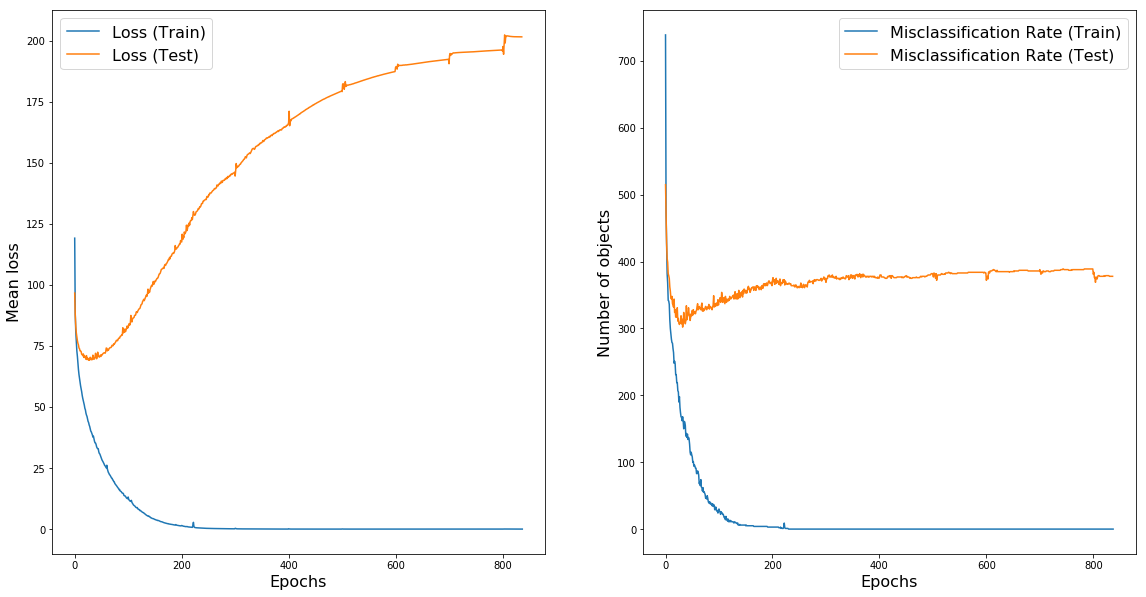

In [37]:
train_(network=net_CIF_fc_s, loss_func=loss_func,
       learning_rate=0.0001, reinit_optim=100,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=2000,
       dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
       )

In [326]:
net_CIF_fc_s_e = Classifier_WITH_EXP_SMALL(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_s_e = net_CIF_fc_s_e.cuda()

Epoch 0... Empirical Loss/Misclassification Rate (Train): 335.166/1014.000	 Empirical Loss/Misclassification Rate (Test): 274.381/1000.000
explinear_params: 
[[ 0.00837973 -0.0085007   0.00090708 ... -0.01989999 -0.00432207
   0.00816479]]
[-0.00275544]
[[0.16858245]]
explinear_params_delta: 
1.4162737
0.05453041
0.34073353

batch_max: 
[0.62192446]
[4.227849]
Epoch 1... Empirical Loss/Misclassification Rate (Train): 262.449/1014.000	 Empirical Loss/Misclassification Rate (Test): 235.083/1000.000
explinear_params: 
[[ 0.00768568 -0.00901705  0.0002017  ... -0.01988534 -0.0044239
   0.007927  ]]
[-0.01478814]
[[0.15612637]]
explinear_params_delta: 
0.07171602
0.0120327035
0.012456089

batch_max: 
[0.56690305]
[1.0839254]
Epoch 2... Empirical Loss/Misclassification Rate (Train): 223.250/1014.000	 Empirical Loss/Misclassification Rate (Test): 207.291/1000.000
explinear_params: 
[[ 0.00708453 -0.00960159 -0.00028476 ... -0.01993089 -0.00451432
   0.00770791]]
[-0.02412618]
[[0.14597088]]
e

0.02296372
0.00062882155
0.0012095943

batch_max: 
[0.06400642]
[47.781174]
Epoch 24... Empirical Loss/Misclassification Rate (Train): 65.553/243.000	 Empirical Loss/Misclassification Rate (Test): 199.293/342.000
explinear_params: 
[[ 0.01487111 -0.00374903  0.00593511 ... -0.02256779 -0.00800697
   0.00241223]]
[-0.06768455]
[[0.08607885]]
explinear_params_delta: 
0.022645455
0.00064942986
0.0012310222

batch_max: 
[0.05756117]
[26.887575]
Epoch 25... Empirical Loss/Misclassification Rate (Train): 63.719/236.000	 Empirical Loss/Misclassification Rate (Test): 107.829/337.000
explinear_params: 
[[ 0.01512644 -0.00359113  0.00614883 ... -0.02285973 -0.00841106
   0.00193529]]
[-0.06690321]
[[0.08753649]]
explinear_params_delta: 
0.023759447
0.0007813424
0.001457639

batch_max: 
[0.05100076]
[38.54961]
Epoch 26... Empirical Loss/Misclassification Rate (Train): 62.227/234.000	 Empirical Loss/Misclassification Rate (Test): 117.886/345.000
explinear_params: 
[[ 0.0153196  -0.00356067  0.0061

Epoch 47... Empirical Loss/Misclassification Rate (Train): 40.513/179.000	 Empirical Loss/Misclassification Rate (Test): 400.771/346.000
explinear_params: 
[[ 0.02719344  0.00383041  0.01182462 ... -0.02463813 -0.01204477
  -0.00288393]]
[-0.03799414]
[[0.1303368]]
explinear_params_delta: 
0.027739402
0.0013720952
0.0016974062

batch_max: 
[0.02197679]
[335.06686]
Epoch 48... Empirical Loss/Misclassification Rate (Train): 40.086/182.000	 Empirical Loss/Misclassification Rate (Test): 312.015/347.000
explinear_params: 
[[ 0.02714203  0.00372482  0.01182094 ... -0.02497493 -0.0124706
  -0.00332016]]
[-0.03658131]
[[0.13206501]]
explinear_params_delta: 
0.029661339
0.0014128312
0.0017282069

batch_max: 
[0.02322387]
[97.48109]
Epoch 49... Empirical Loss/Misclassification Rate (Train): 39.428/171.000	 Empirical Loss/Misclassification Rate (Test): 828.921/351.000
explinear_params: 
[[ 0.02787879  0.00419328  0.01202355 ... -0.02430599 -0.01193977
  -0.00279787]]
[-0.03557287]
[[0.13327858]]


Epoch 70... Empirical Loss/Misclassification Rate (Train): 27.777/103.000	 Empirical Loss/Misclassification Rate (Test): 2354.000/343.000
explinear_params: 
[[ 0.03668511  0.00579609  0.01365371 ... -0.02248601 -0.01195163
  -0.00292198]]
[-0.00987556]
[[0.16108954]]
explinear_params_delta: 
0.04706889
0.0004576333
0.00044730306

batch_max: 
[0.07407834]
[160.93239]
Epoch 71... Empirical Loss/Misclassification Rate (Train): 27.167/106.000	 Empirical Loss/Misclassification Rate (Test): 5191.392/337.000
explinear_params: 
[[ 0.03680121  0.00544556  0.01333802 ... -0.02286428 -0.01245814
  -0.00333522]]
[-0.008661]
[[0.16228026]]
explinear_params_delta: 
0.032482326
0.0012145629
0.001190722

batch_max: 
[0.07844593]
[780.95996]
Epoch 72... Empirical Loss/Misclassification Rate (Train): 27.386/110.000	 Empirical Loss/Misclassification Rate (Test): 2901.537/336.000
explinear_params: 
[[ 0.03718937  0.00547733  0.01330724 ... -0.02250129 -0.01209
  -0.0028626 ]]
[-0.00749704]
[[0.16341433]]


Epoch 93... Empirical Loss/Misclassification Rate (Train): 19.369/59.000	 Empirical Loss/Misclassification Rate (Test): 9346.695/336.000
explinear_params: 
[[ 4.3863215e-02  5.1457160e-03  1.4557183e-02 ... -1.9207949e-02
  -8.2899118e-03  2.4314731e-05]]
[0.0188979]
[[0.18728866]]
explinear_params_delta: 
0.026066536
0.0014262144
0.0012119263

batch_max: 
[0.14794365]
[222.2842]
Epoch 94... Empirical Loss/Misclassification Rate (Train): 18.860/61.000	 Empirical Loss/Misclassification Rate (Test): 3752.744/341.000
explinear_params: 
[[ 0.04435903  0.00537618  0.01482294 ... -0.01892856 -0.00799502
   0.00021534]]
[0.01997577]
[[0.18819672]]
explinear_params_delta: 
0.02678319
0.0010778643
0.00090806186

batch_max: 
[0.1507252]
[215.18808]
Epoch 95... Empirical Loss/Misclassification Rate (Train): 18.708/60.000	 Empirical Loss/Misclassification Rate (Test): 7972.992/341.000
explinear_params: 
[[ 0.04448779  0.00521888  0.01471905 ... -0.01884207 -0.00769009
   0.00044859]]
[0.0212832]
[

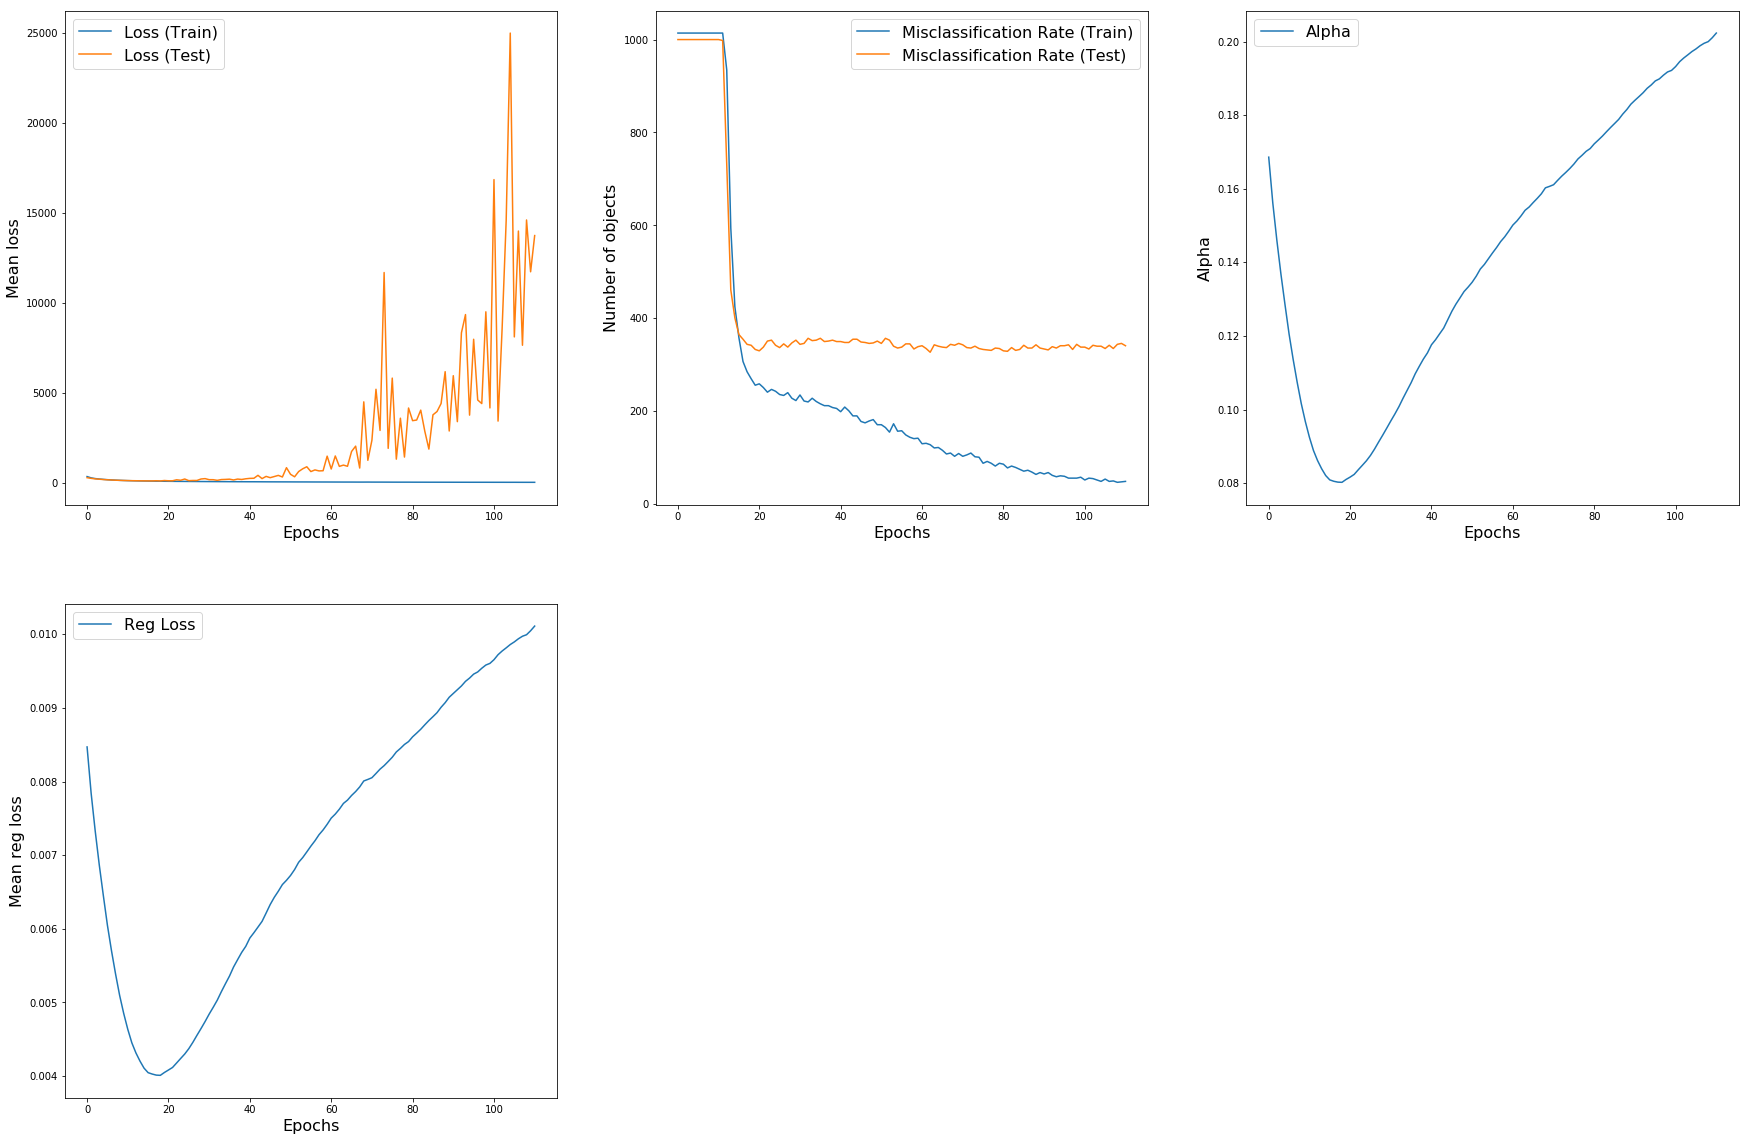

In [327]:
train_EXP(network=net_CIF_fc_s_e, loss_func=loss_func_EXP,
          learning_rate=0.001, reinit_optim=2000,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.05,
          epochs=1000,
          dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
          epoch_hook=hook
         )

In [310]:
def hook(**kwargs):
    if 'cnt' not in hook.__dict__:
        hook.cnt = 0
        hook.prev_explinear_params = deepcopy(dict(kwargs['network'].explinear.named_parameters()))
        dict(kwargs['network'].explinear.named_parameters())['linear.0.weight'].register_hook(print)
    else:
        print('\nexplinear_params: ')
        for name, param in kwargs['network'].explinear.named_parameters():
            print(get_pure(deepcopy(param)))
            
        print('explinear_params_delta: ')
        for name, param in kwargs['network'].explinear.named_parameters():
            print(get_pure((deepcopy(param) - hook.prev_explinear_params[name]).norm(2)))
        hook.prev_explinear_params = deepcopy(dict(kwargs['network'].explinear.named_parameters()))

        bch = next(iter(kwargs['dataloader_test']))[0]
        print('\nbatch_max: ')
        print(max(get_pure(kwargs['network'].linear(bch))))    
        print(max(get_pure(kwargs['network'].explinear(bch))))

In [328]:
for _, param in net_CIF_fc_s_e.linear.named_parameters():
    print( param )

Parameter containing:
tensor([[-4.1851e-02,  1.5068e-02,  1.2326e-02,  ..., -1.0488e-02,
         -4.7672e-02,  3.4242e-03],
        [-1.1706e-02, -6.4700e-03, -5.2218e-02,  ...,  5.4564e-03,
          1.6039e-02,  7.0732e-03],
        [ 2.7923e-02, -2.8706e-02,  5.1639e-02,  ...,  1.6110e-02,
          1.0321e-01,  1.1970e-01],
        [-7.5600e-03,  6.5283e-02,  1.4339e-02,  ...,  7.1214e-02,
         -1.6867e-02,  1.1760e-02],
        [-7.8875e-03,  4.0864e-02,  2.5280e-03,  ...,  4.0106e-02,
          4.7390e-02,  2.9078e-02],
        [ 7.3568e-02, -3.7684e-02,  6.0478e-02,  ...,  2.5299e-02,
          9.6304e-02,  9.2888e-02]], device='cuda:0')
Parameter containing:
tensor([ 0.1129, -0.0173,  0.0385,  0.0608,  0.0169, -0.0172], device='cuda:0')
Parameter containing:
tensor([[ 0.6816,  1.0674, -0.8941,  0.9664,  0.7918, -0.9000],
        [-0.6971, -0.5662,  0.4182, -0.7476, -0.1167,  0.6697],
        [-0.2032, -0.2092,  0.1354, -0.5036, -0.1122, -0.1241]], device='cuda:0')
Paramete

In [329]:
for _, param in net_CIF_fc_s_e.linear.named_parameters():
    bias = torch.zeros_like(param).cuda()
    bias.normal_(0, 0.1)
    param.data += bias

In [336]:
bch, lbls = next(iter(dataloader_CIF_train))
print(bch[0].norm(2))
nn.HingeEmbeddingLoss()(net_CIF_fc_s_e(bch), lbls)**3

tensor(83.5311, device='cuda:0')


tensor(18.8149, device='cuda:0')

In [ ]:
net_WITH_AUG = ClassifierAug_SMALL(32 * 32 * 3).cuda()

In [ ]:
train_STOCH_WITH_AUG(net_WITH_AUG, learning_rate=0.003, reg_lambda=5, epochs=2000,
                     dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test)

In [ ]:
def plot_img(im):
    rr = np.zeros([3, 32, 32])
    rr[0,:,:] = im[:1024].reshape(32, 32)
    rr[1,:,:] = im[1024:2048].reshape(32, 32)
    rr[2,:,:] = im[2048:].reshape(32, 32)
    rr = rr.transpose(1, 2, 0)
    plt.imshow(rr)